### Setup
Change working directory to avoid path error.

In [ ]:
import os
WORKING_DIR = "/Users/thuang/Documents/Personal/code/microscopy-vlm-lpb25/"
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/thuang/Documents/Personal/code/lpb25-quick-start


### Template: CLIP-style vision-language model
* 🧠 The idea being the following:
    * We use a vision encoder to embed the image: change this later to a better encoder for Microscope images
    * We use a text encoder to embed the label: change this later to a better LLM with Bio/Medical knowledge
    * We use Contrastive Loss to train/tune the embeddings so they align in the same space: hence classified
    * This way hopefully we take advantage of the "knowledge" that the SOTA models already got

* 📌 What is exatly being trained here?
    * Pytorch: by default, pytorch set EVERY layer as trainable, including those from the backbone! Unless you explicitly freeze it.

* 📌 Do You *Want* to Train Everything?
    * Pros of Fine-Tuning Everything (NO freezing):
        * Potentially better performance on your specific task (image-text alignment).

    * Cons:
        * Slower training, higher memory usage.
        * Risk of **catastrophic forgetting** — especially for text encoders like BERT that weren’t trained on this kind of simple label input.
        * Might overfit if your dataset is small (e.g., just 5000 samples here).

* #Trainable parameters:
    * Without freezing:

        Image Encoder: 11,307,840 (Resnet18 backbone)

        Text Encoder: 66,559,744 (Distilbert backbone)

    * Freeze all pretrained layers:

        Image Encoder: 131,328 (Resnet18 backbone)

        Text Encoder: 196,864 (Distilbert backbone)


* **"Sweet spot" Experiments:**

    | Trial | Unfrozen ResNet Layers | Unfrozen BERT Layers | #Samples | #Epochs | Training Time | Result |
    | -------- | ------- | ------- | ------- | ------- | ------- | ------- |
    | 1 | None | None | 5056 | 5 | 11 min | Baseline, very fast -> Predict "cat" for everything. |
    | 2 | layer 4 | transformer.layer.5 | 5056 | 7 | 20 min | Likely best trade-off -> Some accuracy spotted! |
    | 3 | layer3, layer4 | last 2 layers | | | | Better, slower -> Haven't tried. |
    | 4 | All | All | 5056 | 10 | 60 min | Max performance if trained sufficiently -> Biased to "bird" or "cat".|

    
        

##### Prep

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from transformers import DistilBertTokenizer, DistilBertModel

# Hyperparams
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
embed_dim = 256
temperature = 0.07
subset_size = 5056
SEED = 42
np.random.seed(SEED)

# Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # for ResNet input
    transforms.ToTensor()
])

# Set download to True when you first need to download the dataset (170 MB)
cifar10 = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform) 
class_names = cifar10.classes

# Randomly select samples for training and testing
total_size = len(cifar10)
random_indices_train = np.random.permutation(total_size)[:subset_size]
random_indices_test = np.random.permutation(total_size)[subset_size:]

# Create subset for training
subset = Subset(cifar10, random_indices_train.tolist())
data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


/Users/thuang/Documents/Personal/code/lpb25-quick-start/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Define Image and Text Encoders

In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim, freeze_backbone=True, unfreeze_layer4=True):
        super().__init__()
        base_model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Remove classifier

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            
            if unfreeze_layer4:
                for name, module in base_model.named_children():
                    if name == "layer4":
                        for param in module.parameters():
                            param.requires_grad = True

        self.fc = nn.Linear(512, embed_dim)  # Trainable projection

    def forward(self, x):
        x = self.backbone(x).squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return F.normalize(x, dim=-1)


class TextEncoder(nn.Module):
    def __init__(self, embed_dim, freeze_backbone=True, unfreeze_layer5=True):
        super().__init__()
        self.backbone = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.fc = nn.Linear(768, embed_dim)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            
            if unfreeze_layer5:
                for name, param in self.backbone.named_parameters():
                    if "transformer.layer.5" in name:
                        param.requires_grad = True                

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state[:, 0, :]  # CLS token
        x = self.fc(x)
        return F.normalize(x, dim=-1)


##### Training Loop with Contrastive Loss

In [13]:
from tqdm import tqdm
import psutil

def contrastive_loss(image_embeds, text_embeds, temperature):
    logits = image_embeds @ text_embeds.T / temperature
    labels = torch.arange(len(image_embeds)).to(device)
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)
    return (loss_i2t + loss_t2i) / 2

# Init models
image_encoder = ImageEncoder(embed_dim, freeze_backbone=False, unfreeze_layer4=False).to(device)
text_encoder = TextEncoder(embed_dim, freeze_backbone=False, unfreeze_layer5=False).to(device)

optimizer = torch.optim.AdamW(list(image_encoder.parameters()) + list(text_encoder.parameters()), lr=1e-4)

# Training loop
for epoch in range(10):  # Keep it short for POC: 3~10 epochs
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch + 1}", unit="batch")
    epoch_loss = 0
    for imgs, labels in progress_bar:
        imgs = imgs.to(device)
        texts = [class_names[i] for i in labels]  # Pretend labels are text
        enc = tokenizer(texts, padding=True, return_tensors="pt", truncation=True).to(device)

        img_embeds = image_encoder(imgs)
        text_embeds = text_encoder(enc['input_ids'], enc['attention_mask'])

        loss = contrastive_loss(img_embeds, text_embeds, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get CPU & RAM usage for display/monitoring
        ram_used = psutil.virtual_memory().used / 1024**3
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item(), ram_used=f"{ram_used:.2f} GB", cpu_usage=f"{psutil.cpu_percent()}%")

    print(f"Epoch {epoch + 1}, Avg Loss: {(epoch_loss/len(progress_bar)):.4f}")

# Epoch 1: 100%|██████████| 79/79 [02:16<00:00,  1.73s/batch, cpu_usage=86.8%, loss=2.87, ram_used=4.83 GB]
# Epoch 1, Avg Loss: 3.4210
# Epoch 2: 100%|██████████| 79/79 [02:13<00:00,  1.69s/batch, cpu_usage=86.6%, loss=2.75, ram_used=4.77 GB]
# Epoch 2, Avg Loss: 2.7719
# Epoch 3: 100%|██████████| 79/79 [02:19<00:00,  1.76s/batch, cpu_usage=88.4%, loss=2.67, ram_used=4.89 GB]
# Epoch 3, Avg Loss: 2.6715

Epoch 1: 100%|██████████| 79/79 [05:58<00:00,  4.54s/batch, cpu_usage=83.3%, loss=2.26, ram_used=4.85 GB]


Epoch 1, Avg Loss: 2.6580


Epoch 2: 100%|██████████| 79/79 [05:51<00:00,  4.44s/batch, cpu_usage=83.5%, loss=2.06, ram_used=5.24 GB]


Epoch 2, Avg Loss: 2.1129


Epoch 3: 100%|██████████| 79/79 [05:24<00:00,  4.10s/batch, cpu_usage=85.7%, loss=1.94, ram_used=4.99 GB]


Epoch 3, Avg Loss: 1.9944


Epoch 4: 100%|██████████| 79/79 [05:41<00:00,  4.32s/batch, cpu_usage=82.7%, loss=1.98, ram_used=4.94 GB]


Epoch 4, Avg Loss: 1.9586


Epoch 5: 100%|██████████| 79/79 [05:44<00:00,  4.36s/batch, cpu_usage=91.2%, loss=2, ram_used=5.35 GB]   


Epoch 5, Avg Loss: 1.9568


Epoch 6: 100%|██████████| 79/79 [07:05<00:00,  5.38s/batch, cpu_usage=87.9%, loss=1.92, ram_used=5.36 GB]


Epoch 6, Avg Loss: 1.9409


Epoch 7: 100%|██████████| 79/79 [06:39<00:00,  5.06s/batch, cpu_usage=87.7%, loss=1.9, ram_used=5.43 GB] 


Epoch 7, Avg Loss: 1.9450


Epoch 8: 100%|██████████| 79/79 [05:25<00:00,  4.12s/batch, cpu_usage=84.7%, loss=1.92, ram_used=4.95 GB]


Epoch 8, Avg Loss: 1.9412


Epoch 9: 100%|██████████| 79/79 [05:27<00:00,  4.15s/batch, cpu_usage=85.1%, loss=1.87, ram_used=4.78 GB]


Epoch 9, Avg Loss: 1.9392


Epoch 10: 100%|██████████| 79/79 [05:40<00:00,  4.31s/batch, cpu_usage=85.6%, loss=2, ram_used=5.07 GB]   

Epoch 10, Avg Loss: 1.9321


##### Inference: Find Best Matching Text for a New Image

In [74]:
print(random_indices_test)

[12014  7303 21254 ... 31991 43664 36174]


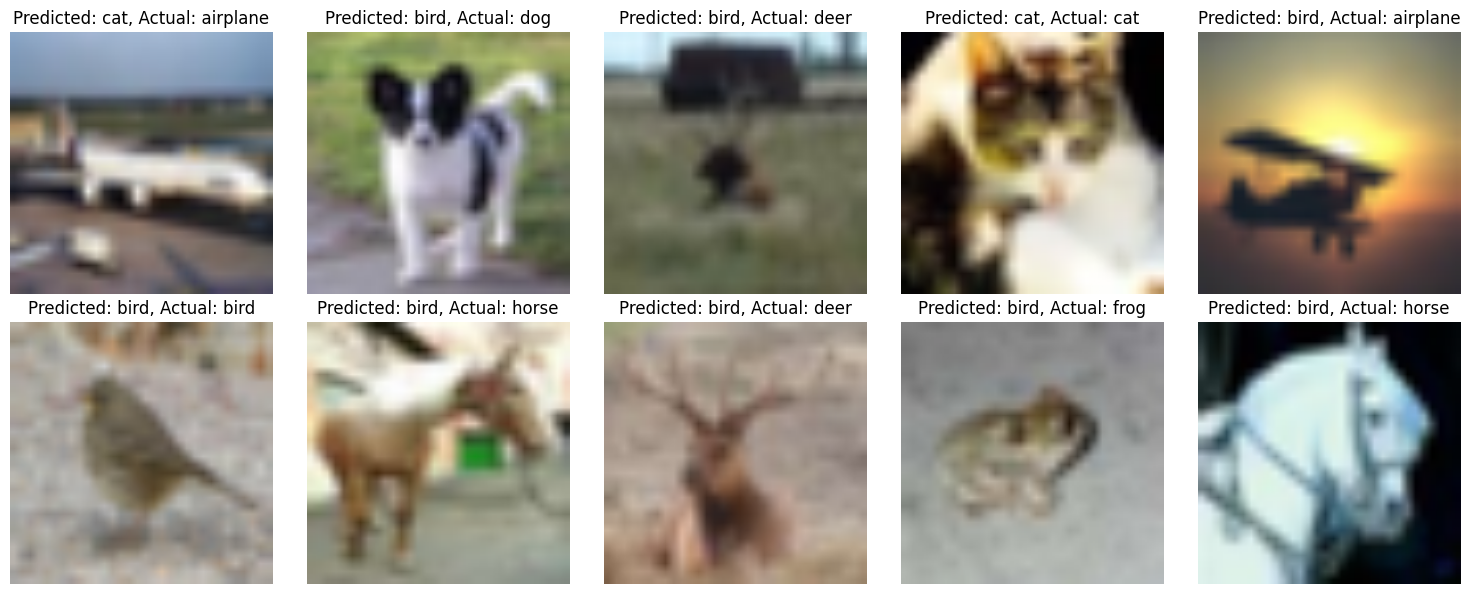

In [16]:
import matplotlib.pyplot as plt

# Sample test image: pick indice from random_indices_test
sample_indices = random_indices_test.tolist()[20:30]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in zip(sample_indices, axes.flatten()):
    test_img, test_label = cifar10[i]
    test_input = test_img.unsqueeze(0).to(device)

    # Encode image
    with torch.no_grad():
        img_embed = image_encoder(test_input)

    # Encode all text labels
    with torch.no_grad():
        texts = tokenizer(class_names, padding=True, return_tensors="pt").to(device)
        text_embeds = text_encoder(texts['input_ids'], texts['attention_mask'])

    # Compute similarity
    sims = (img_embed @ text_embeds.T).squeeze()
    best_match = torch.argmax(sims).item()

    # Vis result
    ax.imshow(test_img.permute(1, 2, 0).numpy())
    ax.axis('off')
    ax.set_title(f"Predicted: {class_names[best_match]}, Actual: {class_names[test_label]}")

plt.tight_layout()
plt.show()

##### Analysis utils

In [6]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Image Encoder:", count_trainable_params(image_encoder))
print("Text Encoder:", count_trainable_params(text_encoder))

Image Encoder: 131328
Text Encoder: 196864


In [7]:
def print_trainable_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Trainable: {name}")

print("Image Encoder:")
print_trainable_layers(image_encoder)
print("Text Encoder:")
print_trainable_layers(text_encoder)

Image Encoder:
Trainable: fc.weight
Trainable: fc.bias
Text Encoder:
Trainable: fc.weight
Trainable: fc.bias


### 👀 Visualize Embeddings

Visualizing the embeddings from image and text encoders (especially before and after training) is one of the best ways to gain **intuition** about:

* Whether the two modalities (vision and language) are learning to align.

* How well the shared **embedding space** is being formed.

* How clustered or separated the classes are.

(Better online embeddings vis tooling?...)


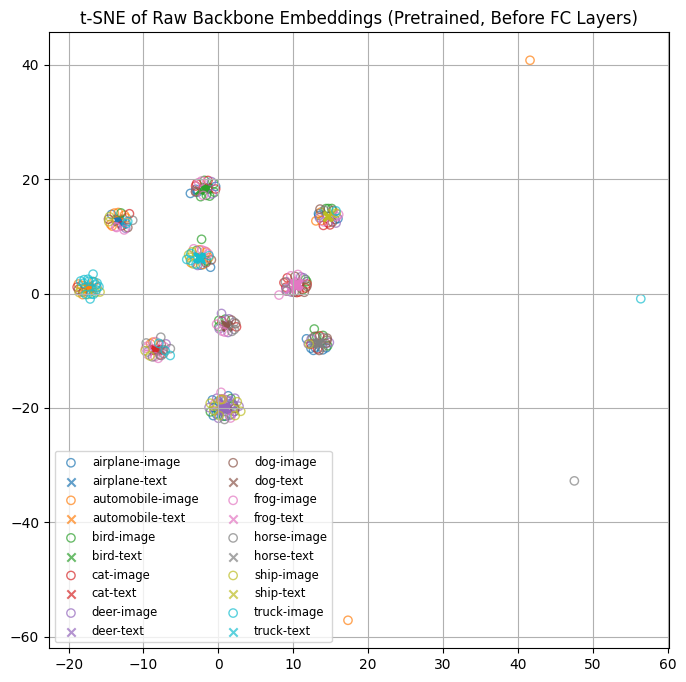

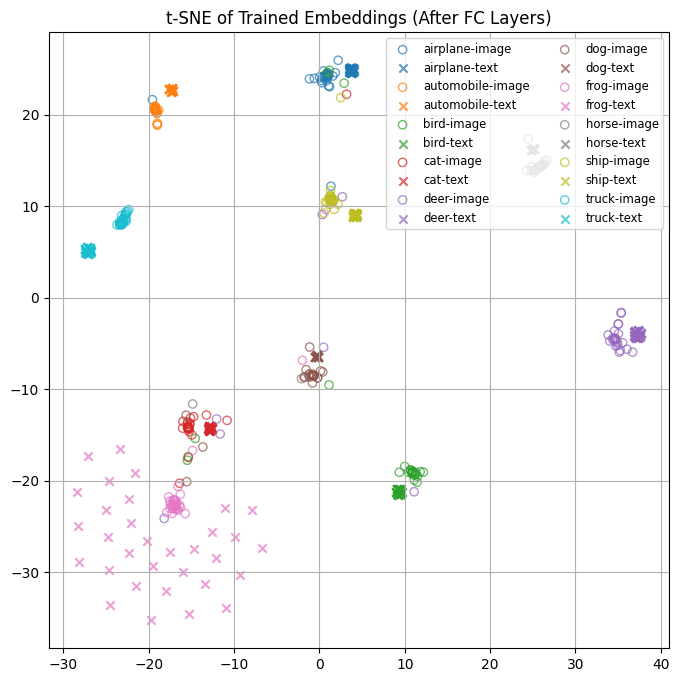

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def get_raw_backbone_embeddings(imgs, labels, image_encoder, text_encoder, tokenizer):
    # Get backbone only (skip fc layer)
    with torch.no_grad():
        # ---- Image backbone ----
        backbone = image_encoder.backbone
        img_feats = backbone(imgs).squeeze(-1).squeeze(-1)  # (B, 512)

        # ---- Text backbone ----
        texts = [cifar10.classes[i] for i in labels]
        encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(imgs.device)
        bert = text_encoder.backbone
        txt_feats = bert(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"]).last_hidden_state[:, 0, :]  # (B, 768)

    return img_feats.cpu(), txt_feats.cpu()


def visualize_embeddings(image_encoder, text_encoder, data_loader, tokenizer, device, n_samples=100, embedding_type="raw"):
    image_encoder.eval()
    text_encoder.eval()

    all_img_embeds = []
    all_txt_embeds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            if embedding_type == "raw":
                # Use raw backbones only
                img_feats, txt_feats = get_raw_backbone_embeddings(imgs, labels, image_encoder, text_encoder, tokenizer)
            elif embedding_type == "trained":
                # Use trained encoders
                img_feats = image_encoder(imgs)
                texts = [cifar10.classes[i] for i in labels]
                encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
                txt_feats = text_encoder(encoded["input_ids"], encoded["attention_mask"])

            all_img_embeds.append(img_feats)
            all_txt_embeds.append(txt_feats)
            all_labels.extend(labels.cpu().numpy())

            if len(all_labels) >= n_samples:
                break

    img_embeds = torch.cat(all_img_embeds, dim=0)[:n_samples]
    txt_embeds = torch.cat(all_txt_embeds, dim=0)[:n_samples]
    all_labels = all_labels[:n_samples]

    # Optional: normalize before t-SNE
    img_embeds = F.normalize(img_embeds, dim=-1)
    txt_embeds = F.normalize(txt_embeds, dim=-1)

    if embedding_type == "raw":
        # Project both to the same dimensionality (e.g., 50D) using PCA
        pca_dim = 256
        img_proj = PCA(n_components=pca_dim).fit_transform(img_embeds.numpy())
        txt_proj = PCA(n_components=pca_dim).fit_transform(txt_embeds.numpy())
    elif embedding_type == "trained":
        img_proj = img_embeds
        txt_proj = txt_embeds

    # Combine for t-SNE
    combined = np.vstack([img_proj, txt_proj])
    labels = np.array(all_labels * 2)
    modalities = np.array(["image"] * n_samples + ["text"] * n_samples)

    # Standardize before t-SNE
    combined = StandardScaler().fit_transform(combined)

    # t-SNE to 2D
    tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
    reduced = tsne.fit_transform(combined)

    # Plot
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('tab10') # 10 colors from the 'tab10' colormap
    for i, label in enumerate(np.unique(labels)):
        for modality in ["image", "text"]:
            idx = (labels == label) & (modalities == modality)

            # dynamic arguments
            scatter_kwargs = {
                'label': f"{cifar10.classes[label]}-{modality}",
                'alpha': 0.7,
                'marker': "x" if modality == "text" else "o"
            }
            if scatter_kwargs['marker'] == 'x':
                scatter_kwargs['color'] = colors(i)
            else:
                scatter_kwargs['facecolors'] = 'none'
                scatter_kwargs['edgecolors'] = colors(i)

            plt.scatter(reduced[idx, 0], reduced[idx, 1], **scatter_kwargs)

    plt.legend(loc="best", fontsize="small", ncol=2)
    if embedding_type == "raw":
        plt.title("t-SNE of Raw Backbone Embeddings (Pretrained, Before FC Layers)")
    elif embedding_type == "trained":
        plt.title("t-SNE of Trained Embeddings (After FC Layers)")
    plt.grid(True)
    plt.show()

# Create subset for testing
subset_test = Subset(cifar10, random_indices_test.tolist())
data_loader_test = DataLoader(subset_test, batch_size=batch_size, shuffle=False)

# Init models to ensure we get untrained embeddings
image_encoder_raw = ImageEncoder(embed_dim, freeze_backbone=True).to(device)
text_encoder_raw = TextEncoder(embed_dim, freeze_backbone=True).to(device)

visualize_embeddings(image_encoder_raw, text_encoder_raw, data_loader_test, tokenizer, device, n_samples=256, embedding_type="raw")
visualize_embeddings(image_encoder, text_encoder, data_loader_test, tokenizer, device, n_samples=256, embedding_type="trained")


### 🧪 Extension Ideas
Once this is running:

* 🔬 Swap CIFAR-10 for RxRx1 or Cell Painting images

* 🧬 Replace text with drug metadata, MoA, or SMILES embeddings

* ⚗️ Try BioGPT instead of DistilBERT

Follow prompt:

"Want to scale this to real drug screening or swap in microscopy data next? I can walk you through converting RxRx1 or JUMP-CP datasets into vision-language pairs. Let me know when you're ready!"
